<a href="https://colab.research.google.com/github/alina-ohloblina/ecommerce-user-engagement-sql/blob/main/Pythonproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading and inspecting the Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load datasets
events = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/events.csv')
products = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/products.csv')
countries = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/countries.csv')

# Clean column names
for df in [events, products, countries]:
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Preview
print(events.head())
print(products.head())
print(countries.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
    order_id order_date   ship_date order_priority country_code  product_id  \
0  100640618  10/8/2014  10/18/2014              M          NOR        2103   
1  100983083  8/11/2016   8/11/2016              C          SRB        2103   
2  101025998  7/18/2014   8/11/2014              M          NaN        7940   
3  102230632  5/13/2017   6/13/2017              L          MNE        2455   
4  103435266  8/11/2012   9/18/2012              H          SRB        1270   

  sales_channel  units_sold  unit_price  unit_cost  
0        Online       650.0      205.70     117.11  
1       Offline      1993.0      205.70     117.11  
2        Online      4693.0      668.27     502.54  
3        Online      1171.0      109.28      35.84  
4       Offline      7648.0       47.45      31.79  
     id        item_type
0  2103           Cereal
1  7940        Household
2  

Data Cleaning

In [ ]:
# Rename for merge
products = products.rename(columns={'id': 'product_id'})

# Convert types
events['order_date'] = pd.to_datetime(events['order_date'], errors='coerce')
events['ship_date'] = pd.to_datetime(events['ship_date'], errors='coerce')

events['units_sold'] = pd.to_numeric(events['units_sold'], errors='coerce')
events['unit_price'] = pd.to_numeric(events['unit_price'], errors='coerce')
events['unit_cost'] = pd.to_numeric(events['unit_cost'], errors='coerce')

# Drop duplicates
events = events.drop_duplicates(subset='order_id')

# Drop rows with critical missing values
events = events.dropna(subset=['order_date', 'ship_date', 'units_sold', 'unit_price', 'unit_cost'])

# Remove anomalies
events = events[(events['units_sold'] > 0) & (events['unit_price'] > 0) & (events['unit_cost'] > 0)]
events = events[events['ship_date'] >= events['order_date']]

Merging Tables

In [ ]:
events = events.merge(
    countries[['alpha-3', 'region', 'sub-region']],
    left_on='country_code',
    right_on='alpha-3',
    how='left'
).drop(columns=['alpha-3'])

events = events.merge(
    products[['product_id', 'item_type']],
    on='product_id',
    how='left'
)


Additional features

In [ ]:
events['revenue'] = events['units_sold'] * events['unit_price']
events['cost'] = events['units_sold'] * events['unit_cost']
events['profit'] = events['revenue'] - events['cost']
events['shipping_delay'] = (events['ship_date'] - events['order_date']).dt.days
events['weekday'] = events['order_date'].dt.day_name()

Key Metrics

In [ ]:
print("Total Orders:", events['order_id'].nunique())
print("Total Revenue: $", round(events['revenue'].sum(), 2))
print("Total Profit: $", round(events['profit'].sum(), 2))
print("Countries Covered:", events['country_code'].nunique())
print("Average Shipping Delay:", round(events['shipping_delay'].mean(), 2))

Total Orders: 1328
Total Revenue: $ 1702129408.21
Total Profit: $ 501434459.0
Countries Covered: 45
Average Shipping Delay: 24.79


Visualizations

Profit by product category

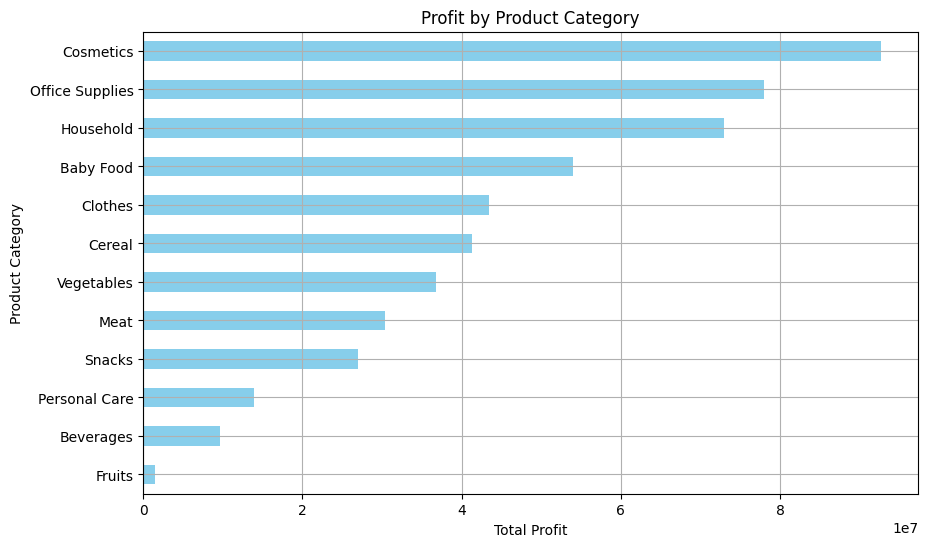

In [ ]:
plt.figure(figsize=(10,6))
events.groupby('item_type')['profit'].sum().sort_values().plot(kind='barh', color='skyblue')
plt.title('Profit by Product Category')
plt.xlabel('Total Profit')
plt.ylabel('Product Category')
plt.grid(True)
plt.show()

Revenue by region

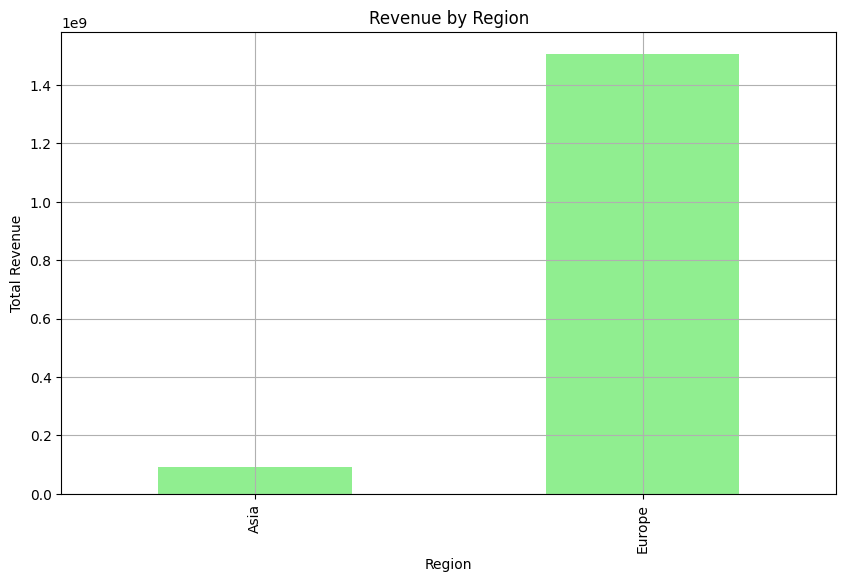

In [ ]:
plt.figure(figsize=(10,6))
events.groupby('region')['revenue'].sum().sort_values().plot(kind='bar', color='lightgreen')
plt.title('Revenue by Region')
plt.xlabel('Region')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.show()

Profit by sales channel

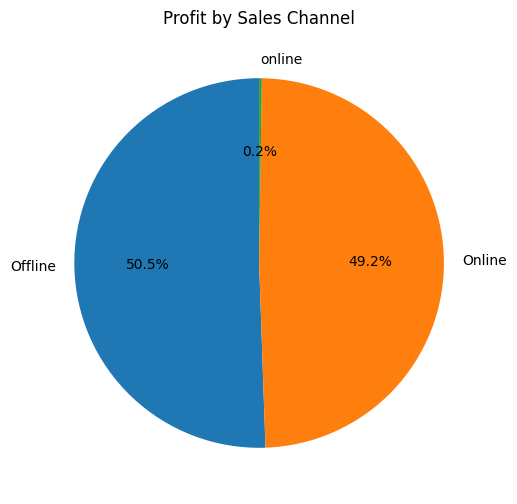

In [ ]:
plt.figure(figsize=(6,6))
events.groupby('sales_channel')['profit'].sum().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Profit by Sales Channel')
plt.ylabel('')
plt.show()

Shipping delay by category

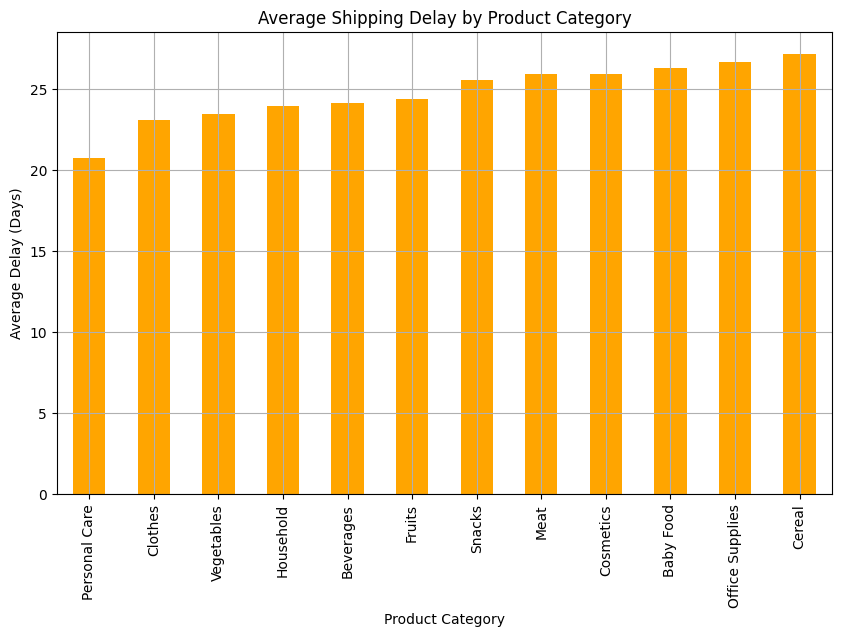

In [ ]:
plt.figure(figsize=(10,6))
events.groupby('item_type')['shipping_delay'].mean().sort_values().plot(kind='bar', color='orange')
plt.title('Average Shipping Delay by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Average Delay (Days)')
plt.grid(True)
plt.show()

Shipping delay by region

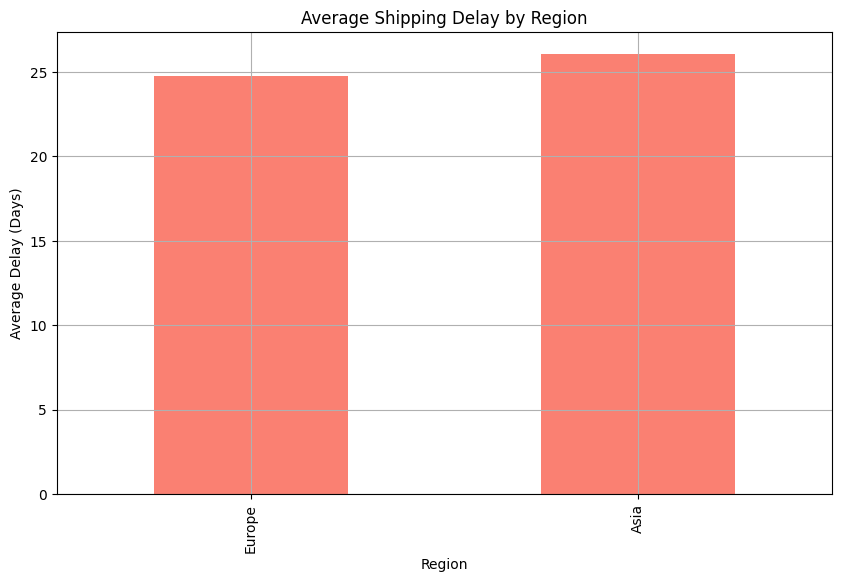

In [ ]:
plt.figure(figsize=(10,6))
events.groupby('region')['shipping_delay'].mean().sort_values().plot(kind='bar', color='salmon')
plt.title('Average Shipping Delay by Region')
plt.xlabel('Region')
plt.ylabel('Average Delay (Days)')
plt.grid(True)
plt.show()

Profit vs Shipping delay

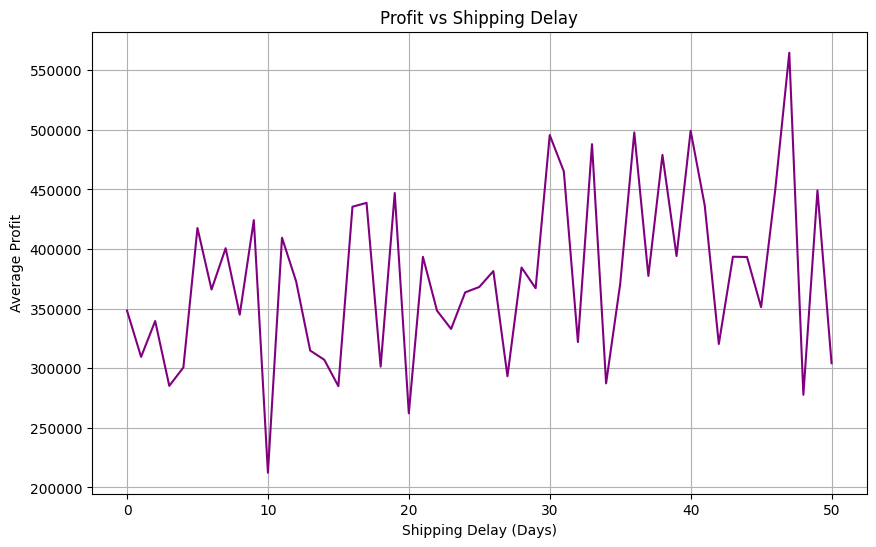

In [ ]:
plt.figure(figsize=(10,6))
events.groupby('shipping_delay')['profit'].mean().plot(color='purple')
plt.title('Profit vs Shipping Delay')
plt.xlabel('Shipping Delay (Days)')
plt.ylabel('Average Profit')
plt.grid(True)
plt.show()

Monthly revenue trend

/tmp/ipython-input-4031205711.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  events.set_index('order_date').resample('M')['revenue'].sum().plot(color='teal')


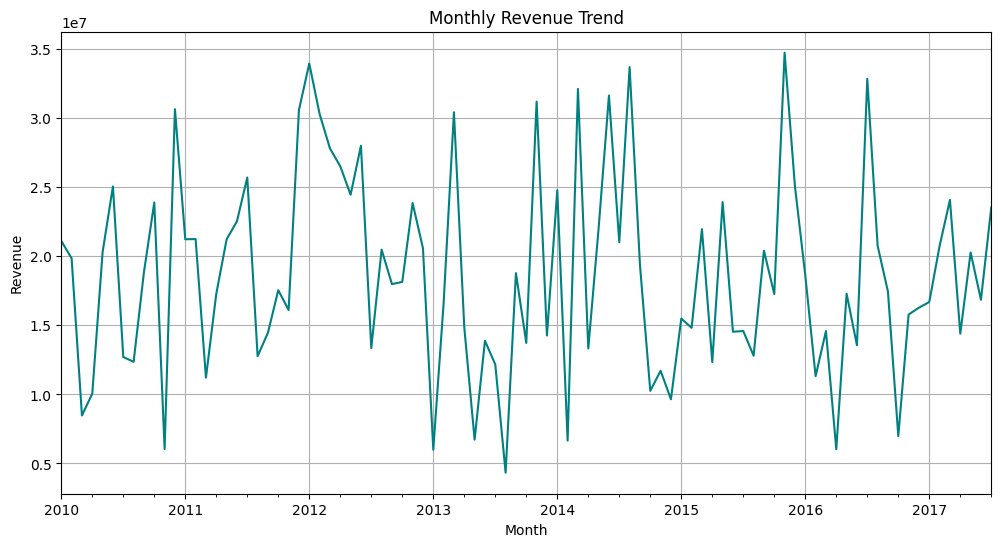

In [ ]:
plt.figure(figsize=(12,6))
events.set_index('order_date').resample('M')['revenue'].sum().plot(color='teal')
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

Orders by Weekday

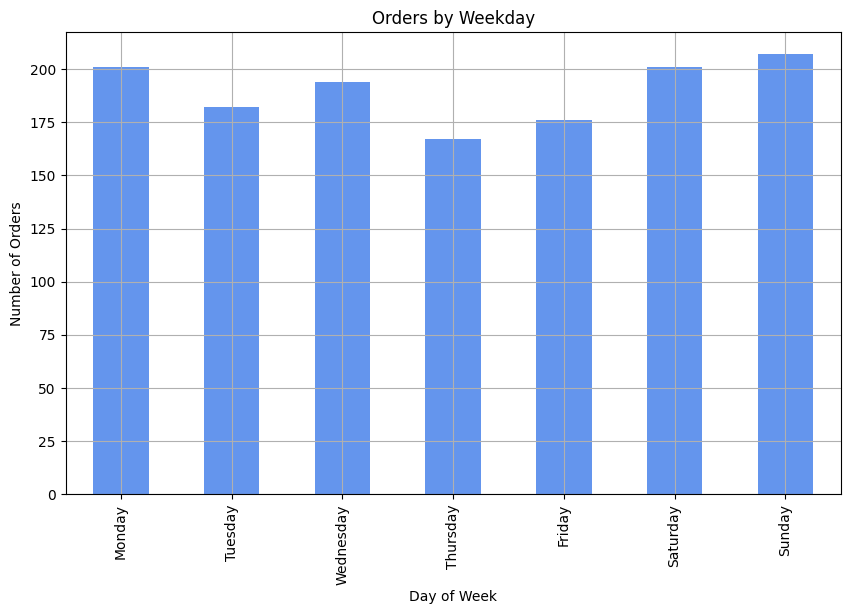

In [ ]:
plt.figure(figsize=(10,6))
events['weekday'].value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]).plot(kind='bar', color='cornflowerblue')
plt.title('Orders by Weekday')
plt.xlabel('Day of Week')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()

Week sales by product category

<Figure size 1200x600 with 0 Axes>

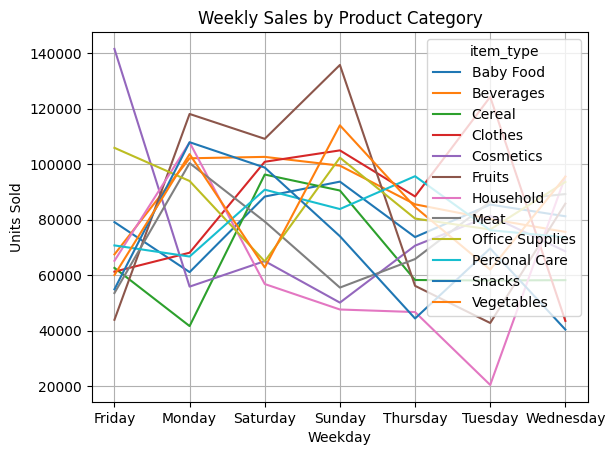

In [ ]:
plt.figure(figsize=(12,6))
events.groupby(['item_type', 'weekday'])['units_sold'].sum().unstack().T.plot()
plt.title('Weekly Sales by Product Category')
plt.xlabel('Weekday')
plt.ylabel('Units Sold')
plt.grid(True)
plt.show()

Monthly revenue by region

/tmp/ipython-input-2711236926.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  events.groupby(['region', 'order_date'])['revenue'].sum().unstack(level=0).resample('M').sum().plot()


<Figure size 1200x600 with 0 Axes>

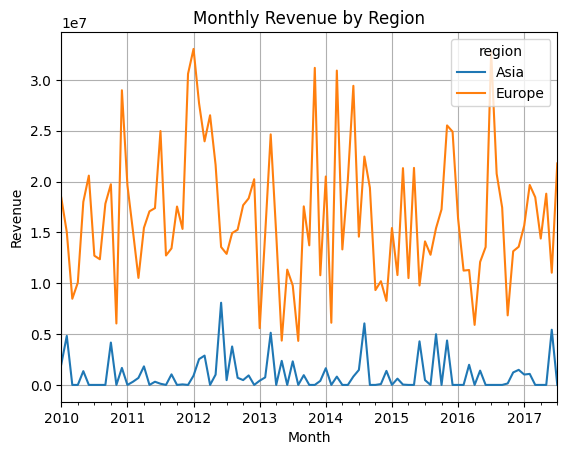

In [ ]:
plt.figure(figsize=(12,6))
events.groupby(['region', 'order_date'])['revenue'].sum().unstack(level=0).resample('M').sum().plot()
plt.title('Monthly Revenue by Region')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

 Business Insights

## 💡 Business Insights

### 📦 Most Profitable Categories
Based on the profit by product category chart, the top-performing categories are:
- **Cosmetics**
- **Office Supplies**
- **Household**

These categories consistently generate the highest margins, making them ideal for strategic investment and promotional focus.

---

### 🌍 Regions with Longest Shipping Delays
The shipping delay by region chart shows that:
- **Asia** has the highest average delay.

This may negatively impact customer satisfaction and retention. Logistics improvements in this region could lead to better performance and happier customers.

---

### 🛒 Sales Channel Performance
The pie chart reveals:
- **Offline channels** generate more profit than online channels.

This suggests a strategic focus on offline operations may yield better financial results. Consider enhancing in-store experiences or expanding physical presence.

---

### 📆 Seasonal Trends
Monthly revenue trends and weekday sales patterns indicate:
- **March, June, and November** show higher activity, with consistent revenue peaks.
- These months may align with promotional cycles, product launches, or regional holidays.

Additionally:
- **Fridays and Mondays** tend to have elevated order volumes.

This insight supports strategic timing for marketing campaigns, inventory restocking, and staffing decisions.

---

### ✅ Summary
These insights highlight key areas for optimization:
- Prioritize high-margin categories.
- Address regional shipping delays.
- Leverage offline channels.
- Align operations with seasonal and weekly demand patterns.
